In [1]:
#NOTE!!!...........use when checking for toronto dataset only
import scipy.misc
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        
        self.dataset_name = dataset_name
        self.img_res = img_res
    
    def genlistsfortarget(self,batchA,dtype):
        halfname= ('./datasets/torontomap/%s/target\\'%(dtype))
        listgen=[]
        for i in batchA:
            var= str(i)
            var1= var.split('\\')
            newname= halfname + var1[1]
            listgen.append(newname)
        return listgen

    
    def load_data(self, batch_size=1, is_testing=False):
        data_type = "valid" if not is_testing else "test"
        #path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))
        path1 = glob('./datasets/%s/%s/input/*' % (self.dataset_name, data_type))
        path2 = glob('./datasets/%s/%s/target/*' % (self.dataset_name, data_type))

        batch_images1 = np.random.choice(path1, size=batch_size)
        batch_images2 = self.genlistsfortarget(batch_images1, data_type)
        imgs_A = []
        imgs_B = []
       
        for img_path1 in batch_images1:
            img1 = self.imread(img_path1)
            img_A= img1
            img_A = scipy.misc.imresize(img_A, self.img_res)
            imgs_A.append(img_A)
           
        
        for img_path2 in batch_images2:
            img2 = self.imread(img_path2)
            img_B= img2
            img_B = scipy.misc.imresize(img_B, self.img_res)
            imgs_B.append(img_B)
           

        imgs_A = np.array(imgs_A)/127.5 - 1.
        #imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_B, imgs_A


    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [2]:
#NOTE!!!!............use when testing for map dataloadedr
from mapdata_loader import DataLoader

In [2]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.models import model_from_json
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import numpy as np
import os

Using TensorFlow backend.


In [3]:
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model2.h5")
print("Loaded model from disk")

Loaded model from disk


In [4]:
loaded_model.compile(loss='binary_crossentropy', optimizer= Adam(0.0002, 0.5), metrics=['accuracy'])

In [5]:
data_loader = DataLoader(dataset_name='torontomap',img_res=(256, 256))
imgs_A, imgs_B = data_loader.load_data(batch_size=3)

C:\Users\nov28\Anaconda3\lib\site-packages\ipykernel\__main__.py:56: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\nov28\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\nov28\Anaconda3\lib\site-packages\ipykernel\__main__.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [6]:
os.makedirs('images/tada' , exist_ok=True)
r, c = 3, 3

In [7]:
fake_A = loaded_model.predict(imgs_A)


In [8]:
halo=np.float32(imgs_A)

In [9]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [10]:
print(mse(fake_A[2],halo[2]))

7122.28979534


In [11]:
print(mse(fake_A[1],halo[1]))

3962.29154061


In [12]:
print(mse(fake_A[0],halo[0]))

9008.69985134


In [13]:
print(halo.shape)

(3, 256, 256, 3)


In [10]:
from skimage.measure import compare_ssim as ssim

In [11]:

simlar= ssim((fake_A[0]*0.5 + 0.5), (halo[0]*0.5 + 0.5),multichannel=True,data_range=4000, guassian_weights= False)
print((simlar+1)/2)

0.922243348485


In [12]:
simlar= ssim((fake_A[1]*0.5 + 0.5), (halo[1]*0.5 + 0.5),multichannel=True,data_range=4000, guassian_weights= False)
print((simlar+1)/2)

0.929223226961


In [13]:
simlar= ssim((fake_A[2]*0.5 + 0.5), (halo[2]*0.5 + 0.5),multichannel=True,data_range=4000, guassian_weights= False)
print((simlar+1)/2)

0.911558379546


In [14]:
newtestscore= loaded_model.evaluate(halo, fake_A,verbose=0)

In [15]:
 print("%s: %.2f%%" % (loaded_model.metrics_names[1], 100-newtestscore[1]*100) )

acc: 94.32%


In [16]:
gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

In [17]:
gen_imgs = 0.5 * gen_imgs + 0.5

In [18]:
img1input=gen_imgs[[0]]

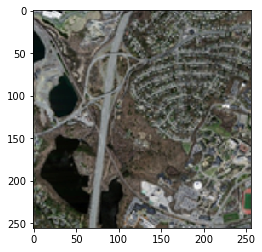

In [19]:
plt.imshow(img1input[0])

In [20]:
img1out=gen_imgs[[3]]

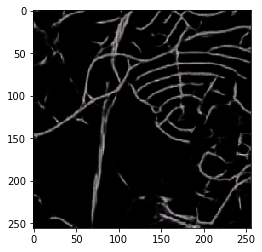

In [21]:
plt.imshow((img1out[0]))


In [22]:
img1target=gen_imgs[[6]]

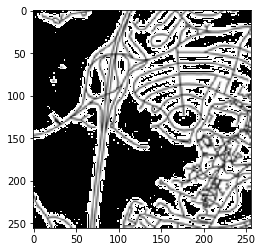

In [23]:
img1target1=((img1target[0]-0.5)/0.5)
plt.imshow(img1target1)

In [24]:
img2input=gen_imgs[[1]]

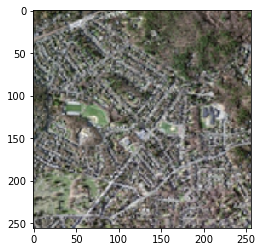

In [25]:
plt.imshow(img2input[0])

In [26]:
img2out=gen_imgs[[4]]

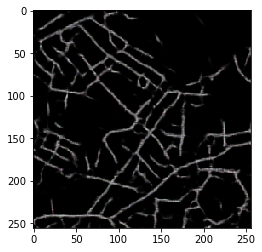

In [27]:
plt.imshow(img2out[0])

In [28]:
img3input=gen_imgs[[2]]

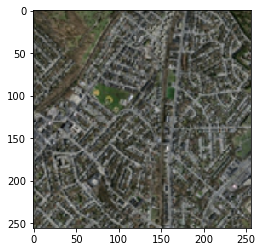

In [29]:
plt.imshow(img3input[0])


In [30]:
img3out=gen_imgs[[5]]

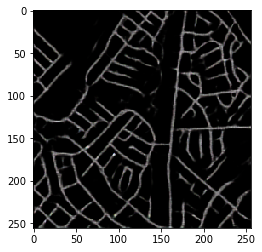

In [31]:
plt.imshow(img3out[0])

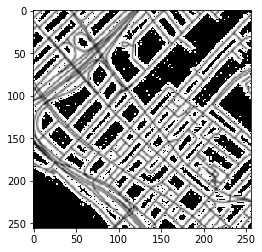

In [32]:
img3target= gen_imgs[[8]]
bluegrey=((img3target[0]-0.5)/0.5)
plt.imshow((bluegrey))